In [45]:
import av
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
# Define base directory path for Google Drive
BASE_DIR = 'data/comma2k19/extracted/Chunk_1/'

class DrivingDataset(Dataset):
    def __init__(self, csv_file, video_path, transform=None):
        self.data = pd.read_csv(csv_file)
        self.video_path = video_path

        # Pre-load all frames into memory
        print("Loading video frames into memory...")
        self.frames = []

        # Open video with PyAV
        container = av.open(video_path)
        stream = container.streams.video[0]
        stream.thread_type = "AUTO"  # Enable multithreading

        frame_dict = {}  # Temporary dictionary to store frames
        frame_index_map = {}  # Map original indices to sequential indices

        # Read all frames first and create index mapping
        print("Reading frames and creating index mapping...")
        for seq_idx, frame in enumerate(container.decode(stream)):
            frame_dict[seq_idx] = frame.to_ndarray(format='rgb24')
            frame_index_map[seq_idx] = seq_idx  # Map sequential index to itself
            if len(frame_dict) % 100 == 0:  # Progress update
                print(f"Loaded {len(frame_dict)} frames...")

        print(f"Total frames in video: {len(frame_dict)}")
        print(f"Frame indices in CSV: {len(self.data)}")
        print(f"Frame index range in video: {min(frame_index_map.keys())} to {max(frame_index_map.keys())}")
        print(f"Frame indices in CSV range: {min(self.data['frame_idx'])} to {max(self.data['frame_idx'])}")

        # Now get only the frames we need using the index mapping
        missing_frames = 0
        for idx in self.data['frame_idx']:
            if idx in frame_index_map:
                seq_idx = frame_index_map[idx]
                frame = Image.fromarray(frame_dict[seq_idx])
                frame = frame.resize((400, 240), Image.Resampling.BILINEAR)
                frame = np.array(frame)
                self.frames.append(frame)
            else:
                missing_frames += 1
                print(f"Warning: Frame {idx} not found in video.")
                # Use the closest available frame as a fallback
                closest_idx = min(frame_index_map.keys(), key=lambda x: abs(x - idx))
                seq_idx = frame_index_map[closest_idx]
                print(f"Using closest frame {closest_idx} (sequential index: {seq_idx}) instead.")
                frame = Image.fromarray(frame_dict[seq_idx])
                frame = frame.resize((400, 240), Image.Resampling.BILINEAR)
                frame = np.array(frame)
                self.frames.append(frame)

        container.close()
        print(f"Successfully loaded {len(self.frames)} frames")
        if missing_frames > 0:
            print(f"Warning: {missing_frames} frames were missing and replaced with closest matches")

        # Define default transforms if none provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        row = self.data.iloc[idx]
        steering_angle = row['steering_angle']

        extra_inputs = np.array([
            (row['steering_angle_prev_100ms']),
            (row['steering_angle_prev_200ms']),
        ], dtype=np.float32)

        if self.transform:
            frame = self.transform(frame)

        extra_inputs = torch.tensor(extra_inputs, dtype=torch.float32)

        return (frame, extra_inputs), torch.tensor(steering_angle, dtype=torch.float32)

def find_all_segments():
    """
    Find all available CSV files and their corresponding video paths.
    Returns a list of tuples (csv_path, video_path).
    """
    # Find all CSV files in the generated directory
    csv_files = glob.glob('data/generated/synced_steer_data_short_*_SEG*.csv')

    segment_pairs = []
    for csv_path in csv_files:
        #print ("CHZ csv path: ", csv_path)
        # Extract main directory and segment from CSV filename
        main_dir = csv_path.split('_')[-2]
        segment = csv_path.split('_')[-1].replace('.csv', '').replace('SEG', '')

        # Construct video path using BASE_DIR
        video_path = f'{BASE_DIR}/{main_dir}/{segment}/video.hevc'
        #print ("CHZ video path: ", video_path)
        # Check if video file exists
        if os.path.exists(video_path):
            segment_pairs.append((csv_path, video_path))
        else:
            print(f"Warning: Video file not found for {csv_path}")

    print(f"Found {len(segment_pairs)} valid segment pairs")
    return segment_pairs



In [75]:
# Find all available segments
segment_pairs = find_all_segments()
# Create a combined dataset from all segments
class CombinedDrivingDataset(Dataset):
    def __init__(self, segment_pairs, transform=None, save_combined_csv=True):
        self.datasets = []
        combined_data = []
        counter = 0
        for csv_path, video_path in segment_pairs:
            #if (counter > 60):
            #    break
            try:
                # Load the CSV data
                data = pd.read_csv(csv_path)
                # Add columns to track the source files
                data['source_csv'] = csv_path
                data['source_video'] = video_path
                combined_data.append(data)

                # Create dataset instance
                dataset = DrivingDataset(csv_path, video_path, transform)
                self.datasets.append(dataset)
                print(f"Successfully loaded dataset from {csv_path}")
            except Exception as e:
                print(f"Error loading dataset from {csv_path}: {str(e)}")
            counter = counter + 1

        # Combine all CSV data
        if combined_data:
            self.combined_csv = pd.concat(combined_data, ignore_index=True)
            if save_combined_csv:
                output_path = "data/generated/combined_steering_data.csv"
                self.combined_csv.to_csv(output_path, index=False)
                print(f"\nSaved combined dataset to: {output_path}")
                print(f"Total rows in combined CSV: {len(self.combined_csv)}")
                print("Columns in combined CSV:")
                print(self.combined_csv.columns.tolist())

        # Combine all datasets
        self.combined_dataset = ConcatDataset(self.datasets)
        print(f"\nTotal number of samples across all segments: {len(self.combined_dataset)}")

    def __len__(self):
        return len(self.combined_dataset)

    def __getitem__(self, idx):
        return self.combined_dataset[idx]

def load_combined_dataset(combined_csv_path="/data/comma2k19/extracted/Chunk_1/combined_steering_data.csv", transform=None):
    """
    Quickly load the combined dataset from the saved CSV file.
    
    Args:
        combined_csv_path: Path to the combined CSV file
        transform: Optional transform to apply to the images

    Returns:
        CombinedDrivingDataset instance
    """
    if not os.path.exists(combined_csv_path):
        print(f"Combined CSV file not found at {combined_csv_path}")
        print("Falling back to loading individual segments...")
        return None

    # Load the combined CSV
    combined_data = pd.read_csv(combined_csv_path)
    print(f"Loaded combined dataset with {len(combined_data)} samples")

    # Extract unique source files
    unique_csvs = combined_data['source_csv'].unique()
    unique_videos = combined_data['source_video'].unique()

    # Create segment pairs
    segment_pairs = list(zip(unique_csvs, unique_videos))
    print(f"Found {len(segment_pairs)} unique segment pairs")

    # Create and return the combined dataset
    return CombinedDrivingDataset(segment_pairs, transform=transform, save_combined_csv=False)

# Initialize combined dataset
print("\nInitializing combined dataset from all segments...")
# Try to load from combined CSV first, fall back to loading individual segments if needed
dataset = load_combined_dataset()
if dataset is None:
    # Find all available segments and load them individually
    segment_pairs = find_all_segments()
    dataset = CombinedDrivingDataset(segment_pairs, save_combined_csv=True)



Found 188 valid segment pairs

Initializing combined dataset from all segments...
Combined CSV file not found at /data/comma2k19/extracted/Chunk_1/combined_steering_data.csv
Falling back to loading individual segments...
Found 188 valid segment pairs
Loading video frames into memory...
Reading frames and creating index mapping...
Loaded 100 frames...
Loaded 200 frames...
Loaded 300 frames...
Loaded 400 frames...
Loaded 500 frames...
Loaded 600 frames...
Loaded 700 frames...
Loaded 800 frames...
Loaded 900 frames...
Loaded 1000 frames...
Loaded 1100 frames...
Loaded 1200 frames...
Total frames in video: 1200
Frame indices in CSV: 61
Frame index range in video: 0 to 1199
Frame indices in CSV range: 0 to 1199
Successfully loaded 61 frames
Successfully loaded dataset from data/generated/synced_steer_data_short_b0c9d2329ad1606b|2018-07-27--06-03-57_SEG10.csv
Loading video frames into memory...
Reading frames and creating index mapping...
Loaded 100 frames...
Loaded 200 frames...
Loaded 300 

In [76]:
# Split dataset into train, validation, and test sets (70%, 15%, 15%)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with larger batch size since we have more data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)




Dataset sizes:
Total samples: 11421
Train: 7994 (70.0%)
Validation: 1713 (15.0%)
Test: 1714 (15.0%)


Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened features size: 1536

Starting training...
Training on cuda:0
Epoch 1/50: Train Loss: 153.4616, Val Loss: 87.9247
Epoch 2/50: Train Loss: 100.4502, Val Loss: 64.3786
Epoch 3/50: Train Loss: 74.4748, Val Loss: 32.8689
Epoch 4/50: Train Loss: 51.8124, Val Loss: 8.4850
Epoch 5/50: Train Loss: 41.2290, Val Loss: 32.4360
Epoch 6/50: Train Loss: 34.2380, Val Loss: 20.8366
Epoch 7/50: Train Loss: 36.1988, Val Loss: 12.5393
Epoch 8/50: Train Loss: 33.4917, Val Loss: 10.7650
Epoch 9/50: Train Loss: 27.8980, Val Loss: 17.5471
Early stopping triggered at epoch 10


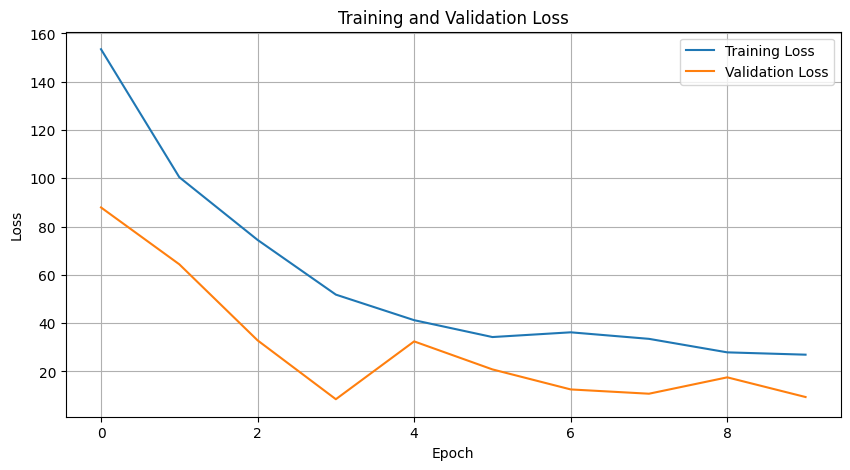


Model saved to 'steering_model.pth'

Testing the model...

Test Results:
MSE: 7.3597 degrees²
MAE: 2.1415 degrees
Predictions within 1°: 12.4%
Predictions within 3°: 85.6%
Predictions within 5°: 97.8%


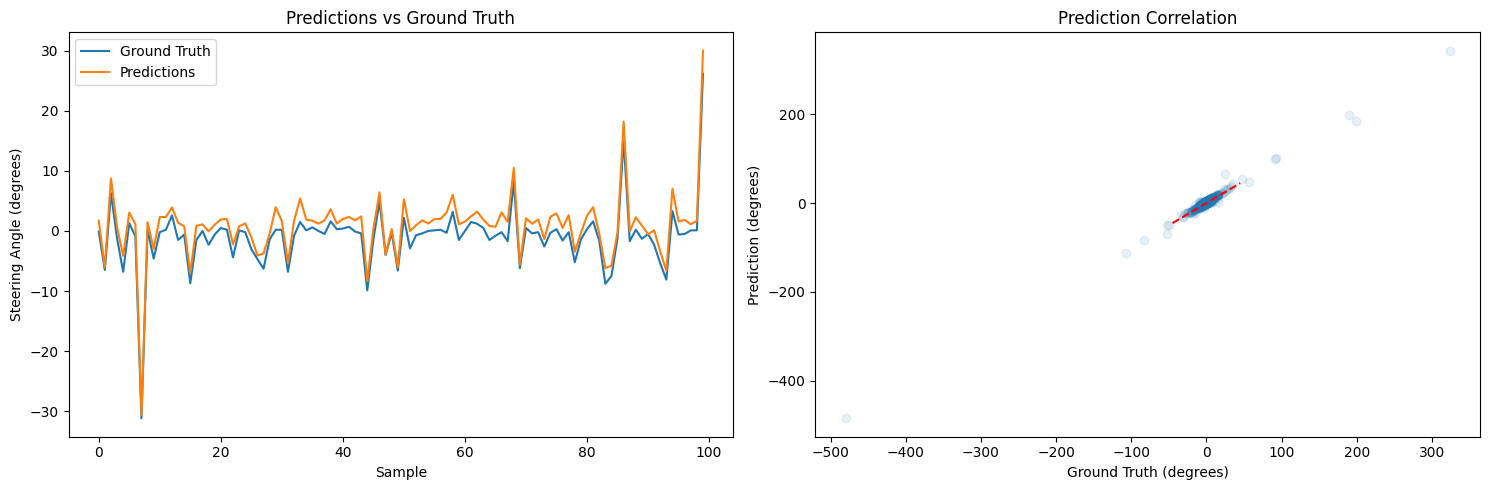


Visualizing some predictions...


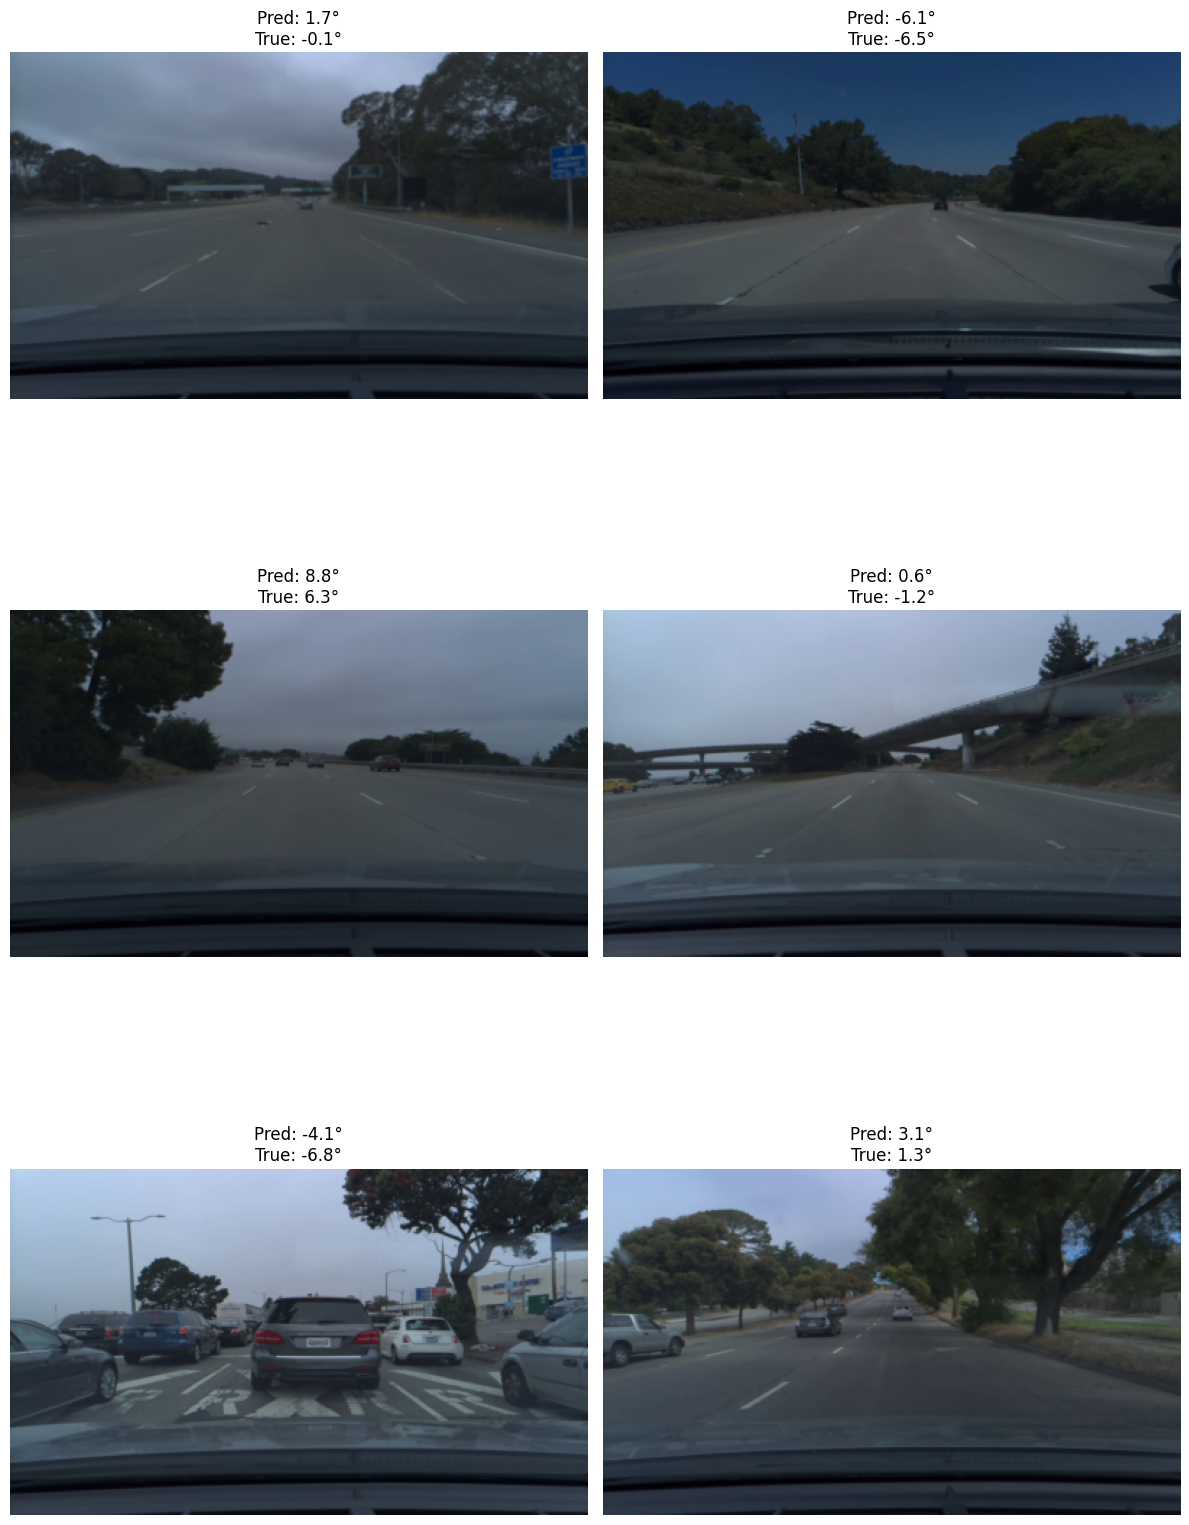

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting steering angles from dashcam images with 2 additional inputs.
    Based on NVIDIA's PilotNet architecture with some simplifications.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()

        self.extra_input_size = 2  # Number of non-image inputs

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),


            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d (kernel_size=2, stride=2),

            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d (kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
        )

        # Temporary placeholder for first linear layer (will update below)
        self.fc_layers = nn.Sequential(
    
            nn.Linear(1, 128),  # Placeholder, updated dynamically
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.20),
            nn.Linear(128, 1),
            #nn.Tanh(),
            #Lambda(lambda x: x * 45)
        )

        # Update the first FC layer with correct input size
        self._calculate_conv_output_size()

    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        x = torch.zeros(1, 3, 240, 400)
        x = self.conv_layers(x)
        flattened_size = x.numel() // x.size(0)

        # Update the first linear layer to include the extra 2 inputs
        self.fc_layers[0] = nn.Linear(flattened_size + self.extra_input_size, 128)

        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened features size: {flattened_size}")

    def forward(self, image, extras):
        """
        image: Tensor of shape (B, 3, H, W)
        extras: Tensor of shape (B, 2)
        """
        x = self.conv_layers(image)
        x = x.view(x.size(0), -1)  # Flatten CNN features
        x = torch.cat([x, extras], dim=1)  # Concatenate with extra inputs
        x = self.fc_layers(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for (images, extras), angles in train_loader:
            images = images.to(device)
            extras = extras.to(device)
            angles = angles.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images, extras)
            loss = criterion(outputs, angles)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for (images, extras), angles in val_loader:
                images = images.to(device)
                extras = extras.to(device)
                angles = angles.to(device).float().view(-1, 1)

                outputs = model(images, extras)
                loss = criterion(outputs, angles)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}')

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curves.png')
    plt.show()

    return model, train_losses, val_losses

def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics (updated to handle extra inputs).
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for (images, extras), angles in test_loader:
            images = images.to(device)
            extras = extras.to(device)
            angles = angles.to(device).float().view(-1, 1)

            outputs = model(images, extras)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(angles.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results:")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualization
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth over first 100 samples
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Ground Truth')
    plt.plot(all_preds[:100], label='Predictions')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predictions vs Ground Truth')
    plt.legend()

    # Correlation scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')  # Ideal line
    plt.xlabel('Ground Truth (degrees)')
    plt.ylabel('Prediction (degrees)')
    plt.title('Prediction Correlation')

    plt.tight_layout()
    plt.savefig('test_results.png')
    plt.show()

# Initialize model, loss function, and optimizer
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,  # You can adjust this
    patience=8      # Early stopping patience
)

# Save the trained model
torch.save(model.state_dict(), 'steering_model.pth')
print("\nModel saved to 'steering_model.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

# Optional: Test on a single batch to visualize predictions
def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch (including extra features)
    (inputs, extras), targets = next(iter(test_loader))
    inputs = inputs.to(device)
    extras = extras.to(device)

    with torch.no_grad():
        predictions = model(inputs, extras)  # Pass both inputs and extras to the model

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = inputs[i].cpu().numpy().transpose(1, 2, 0)

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Pred: {predictions[i][0]:.1f}°\nTrue: {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)